In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import gizmo_analysis as gizmo
import utilities as ut

from func import *
from IPython.utils import io

# Define plotting style
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['patch.linewidth'] = 1

In [2]:
unit_time = 0.978 # [Gyr], as set in Gadget

# make these consistent with gizmo.params
start_time = 0
end_time = 13
time_step = 0.1
time_array = np.arange(start_time, end_time+1, time_step)*unit_time

In [3]:
sim_dir = '/home/chainje/thesis/simulation/halos_only'
mw,  _ = create_galaxy_arrays(f"{sim_dir}/mw", 100000, 1000, 0, 0, time_array)
sgr, _ = create_galaxy_arrays(f"{sim_dir}/sgr", 10000, 100, 0, 0, time_array)

In [4]:
# Check that the masses look correct
print(f"MW total halo mass:  {np.average([sum(snap['dark']['mass']) for snap in mw]):.3e} (expect 1.25e12)")
print(f"MW total disk mass:  {np.average([sum(snap['star']['mass']) for snap in mw]):.3e} (expect 8.125e10)")
print(f"Sgr total halo mass: {np.average([sum(snap['dark']['mass']) for snap in sgr]):.3e} (expect 1.3e10)")
print(f"Sgr total disk mass: {np.average([sum(snap['star']['mass']) for snap in sgr]):.3e} (expect 7.8e8)")

MW total halo mass:  1.188e+12 (expect 1.25e12)
MW total disk mass:  8.128e+10 (expect 8.125e10)
Sgr total halo mass: 1.250e+10 (expect 1.3e10)
Sgr total disk mass: 8.137e+08 (expect 7.8e8)


# Halo

In [5]:
def nfw_dist(r, sgr=True):
    """
    Eq. 26, Wang 2020 (in GalactICS/Papers); values taken from Dierickx and Loeb 2017
                                     MW            Sgr
    M_200  Virial mass               1e12 M_\odot  1e10 M_\odot
    r_200  Virial radius             206 kpc       44 kpc
    c      concentration parameter   10            8
    """
    if sgr: M_200, r_200, c = 1e10, 44, 8
    else:   M_200, r_200, c = 1e12, 206, 10
    f = lambda c: np.log1p(c) - c / (1+c)
    x = r * c / r_200
    return M_200 / (4*np.pi*f(c)*r_200) * c*x / (r * (1+x))**2

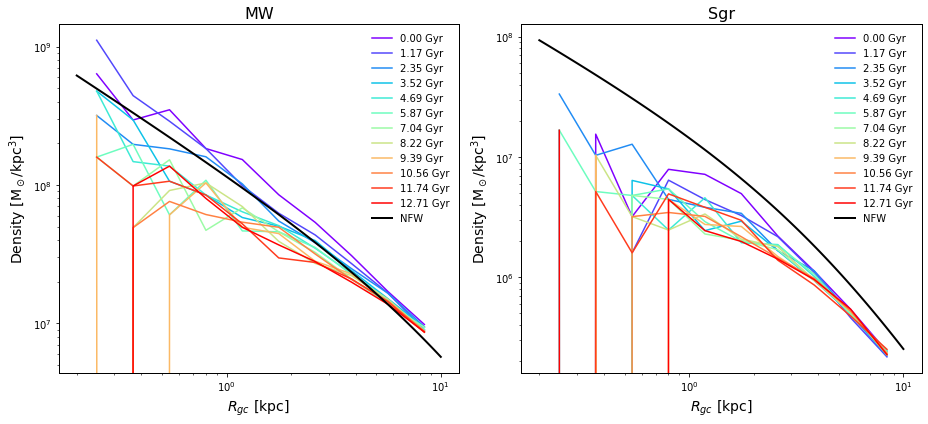

In [6]:
def make_density_hist(ls, min_radius, max_radius, nbins):
    hist, bin_edges = np.histogram(ls['position.sph'][:,0], 
                                   bins=np.logspace(np.log10(min_radius), np.log10(max_radius), nbins+1), 
                                   weights=ls['mass'])
    Rminlist = bin_edges[:-1]
    Rmaxlist = bin_edges[1:]
    Rcenterlist = (Rmaxlist + Rminlist) / 2
    shell_vol_list = 4*np.pi/3 * (Rmaxlist**3 - Rminlist**3)
    return Rcenterlist, np.divide(hist, shell_vol_list)


def plot_halo_density_hist(ax, snaps, sgr=True, title='Mass density', xlim=None, ylim=None, scale='log'):
    ilist = list(range(0, len(snaps), 12)) + [len(snaps) - 1]
    colors = plt.cm.rainbow(np.linspace(0, 1, max(ilist)+1))
    for i in ilist:
        radii, densities = make_density_hist(snaps[i]['dark'], 0.2, 10, 10)
        ax.plot(radii, densities, color=colors[i], label=f"{time_array[i]:.2f} Gyr", linewidth=1.5)

    r = np.logspace(np.log10(0.2), np.log10(10), 101)
    ax.plot(r, nfw_dist(r, sgr=sgr), 'k', label='NFW')

    ax.set_xscale(scale)
    ax.set_yscale(scale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$R_{gc}$ [kpc]', fontsize=14)
    ax.set_ylabel('Density [M$_\odot$/kpc$^3$]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(frameon=False, loc='upper right', fontsize=10)


f, axs = plt.subplots(1, 2, figsize=(13,6), tight_layout=True)
plot_halo_density_hist(axs[0], mw, sgr=False, title='MW')
plot_halo_density_hist(axs[1], sgr, sgr=True, title='Sgr')
plt.show()

# Disk

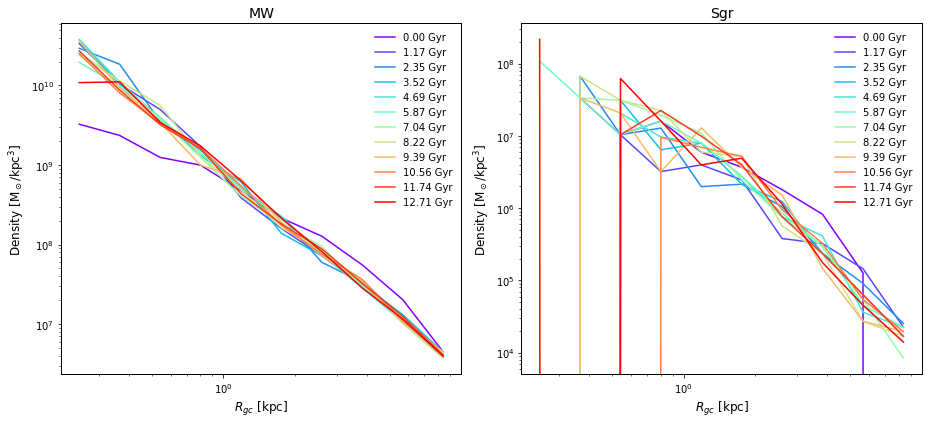

In [7]:
def plot_disk_density_hist(ax, snaps, sgr=True, title='Mass density', xlim=None, ylim=None, scale='log'):
    ilist = list(range(0, len(snaps), 12)) + [len(snaps) - 1]
    colors = plt.cm.rainbow(np.linspace(0, 1, max(ilist)+1))
    for i in ilist:
        radii, densities = make_density_hist(snaps[i]['star'], 0.2, 10, 10)
        ax.plot(radii, densities, color=colors[i], label=f"{time_array[i]:.2f} Gyr", linewidth=1.5)

    ax.set_xscale(scale)
    ax.set_yscale(scale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$R_{gc}$ [kpc]', fontsize=12)
    ax.set_ylabel('Density [M$_\odot$/kpc$^3$]', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(frameon=False, loc='upper right', fontsize=10)


f, axs = plt.subplots(1, 2, figsize=(13,6), tight_layout=True)
plot_disk_density_hist(axs[0], mw, sgr=False, title='MW')
plot_disk_density_hist(axs[1], sgr, sgr=True, title='Sgr')
plt.show()